In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo
import sys
if "../../dft_in_nengo" not in sys.path:
    sys.path.append("../../dft_in_nengo")
from cedar_utils.cedar_modules import NeuralField, GaussKernel, AbsSigmoid
import nengo_dft

In [41]:
class Sigmoid(nengo.neurons.NeuronType):
    def __init__(self, initial_state=None):
        super().__init__(initial_state)

    def step(self, dt, J, output):
        output[...] = 0.5 * (1 + (J) / (1 + np.abs(J)))
        #output[...] = 1.0 / (1 + np.exp(-1.0 * self.beta * (J)));
        

sigmoid = AbsSigmoid(beta=4)
noise = 0
N = 100

x = np.arange(N)
def stim_func(t):
    if t > 0.5:
        return x*0
    else:
        return 7.3*np.exp(-0.5*((x-25)/5)**2) + 7.3*np.exp(-0.5*((x-75)/5)**2)
    

# cedar parameters
time_scale = 20
fake_dt_factor = 0.5

dt = fake_dt_factor * 0.02
tau = time_scale * 0.05
sample_every=0.001


h = -4

c_glob = -0.9


model = nengo.Network()
with model:
    dft1a_kernels = [GaussKernel(c=17.5, sigma=5, normalize=True, dims=1),
                     GaussKernel(c=-15, sigma=10, normalize=True, dims=1)]
    v1a = NeuralField(sizes=[N], h=h, tau=tau,
                        kernel=dft1a_kernels, c_glob=c_glob,
                        nonlinearity=sigmoid, input_noise_gain=noise)
    v1a.make_node()

    dft1b_kernels = GaussKernel(c=21, sigma=5, normalize=True, dims=1)
    v1b = NeuralField(sizes=[N], h=h, tau=tau,
                        kernel=dft1b_kernels, c_glob=c_glob,
                        nonlinearity=sigmoid, input_noise_gain=noise)
    v1b.make_node()
    
    dft1c_kernels = [GaussKernel(c=30, sigma=5, normalize=True, dims=1),
                     GaussKernel(c=-27.5, sigma=10, normalize=True, dims=1)]   
    v1c = NeuralField(sizes=[N], h=h, tau=tau,
                        kernel=dft1c_kernels, c_glob=0,
                        nonlinearity=sigmoid, input_noise_gain=noise)
    v1c.make_node()
    

    v2a = nengo_dft.DFT(shape=[N], global_inh=-c_glob, h=h, dt=dt, tau=tau, c_noise=noise,
                       )
    v2a.g.neuron_type = Sigmoid()
    ka = v2a.add_kernel(exc=17.5, inh=15, epsilon=0.01)
    
    
    
    v2b = nengo_dft.DFT(shape=[N], global_inh=-c_glob, h=h, dt=dt, tau=tau, c_noise=noise,
                       )
    v2b.g.neuron_type = Sigmoid()
    kb = v2b.add_kernel(exc=21, inh=0, epsilon=0.45)
    
    v2c = nengo_dft.DFT(shape=[N], global_inh=0, h=h, dt=dt, tau=tau, c_noise=noise,
                       )
    v2c.g.neuron_type = Sigmoid()
    kc = v2c.add_kernel(exc=30, inh=27.5, epsilon=0.01)
    
    
    stim = nengo.Node(stim_func)
    nengo.Connection(stim, v1a.node, synapse=None)
    nengo.Connection(stim, v2a.s, synapse=None)
    nengo.Connection(stim, v1b.node, synapse=None)
    nengo.Connection(stim, v2b.s, synapse=None)
    nengo.Connection(stim, v1c.node, synapse=None)
    nengo.Connection(stim, v2c.s, synapse=None)
    
    p_u_1a = nengo.Probe(v1a.node)
    p_u_2a = nengo.Probe(v2a.u)
    p_u_1b = nengo.Probe(v1b.node)
    p_u_2b = nengo.Probe(v2b.u)
    p_u_1c = nengo.Probe(v1c.node)
    p_u_2c = nengo.Probe(v2c.u)
    
import nengo
sim = nengo.Simulator(model, dt=dt) #dt=0.001 default
with sim:
    sim.run(1.0)



HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

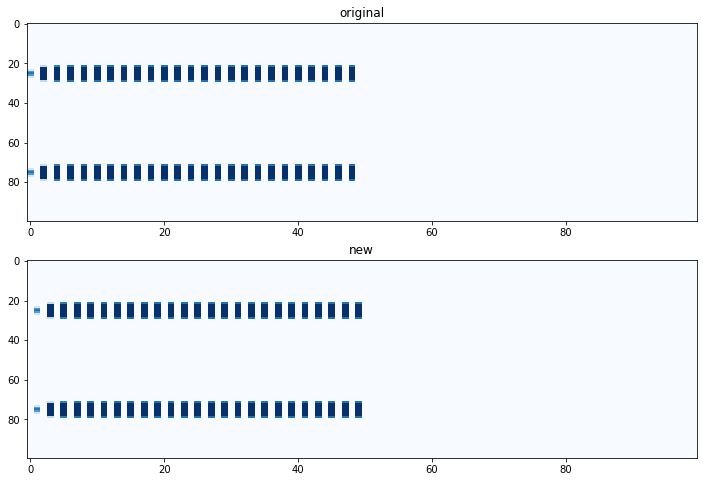

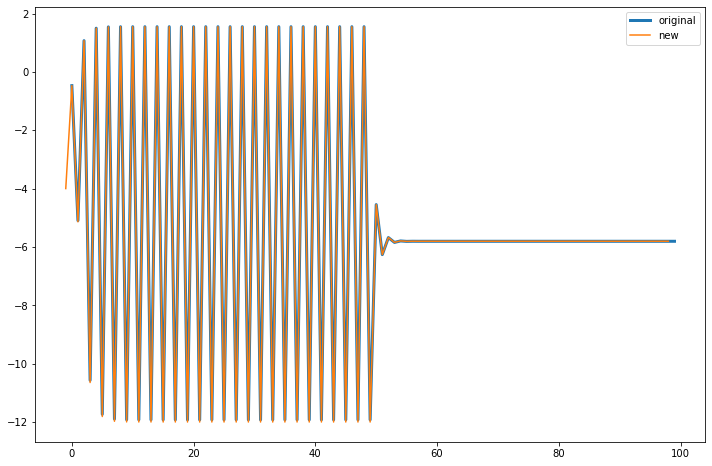

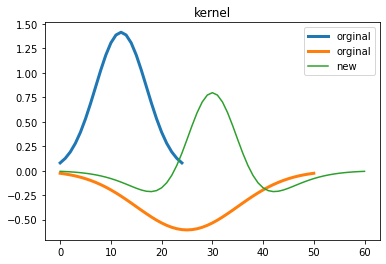

In [42]:

plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
plt.imshow(sim.data[p_u_1a].T, aspect='auto', cmap='Blues', vmin=0, vmax=1, interpolation='none')
plt.title('original')
plt.subplot(2, 1, 2)
plt.imshow(sim.data[p_u_2a].T, aspect='auto', cmap='Blues', vmin=0, vmax=1, interpolation='none')
plt.title('new')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(sim.data[p_u_1a][:,22], lw=3, label='original')
plt.plot(np.arange(100)-1, sim.data[p_u_2a][:,22], label='new')
plt.legend()
plt.show()

for kk in dft1a_kernels:
    plt.plot(kk.kernel_matrix, lw=3, label='orginal')
plt.plot(ka, label='new')
plt.legend()
plt.title('kernel')
plt.show()

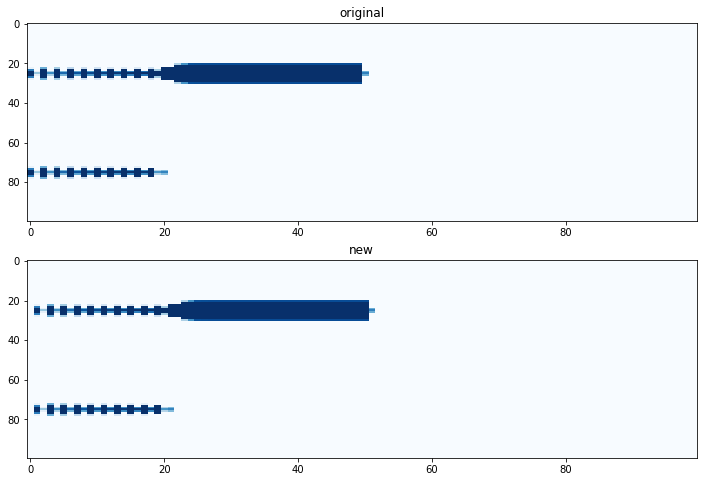

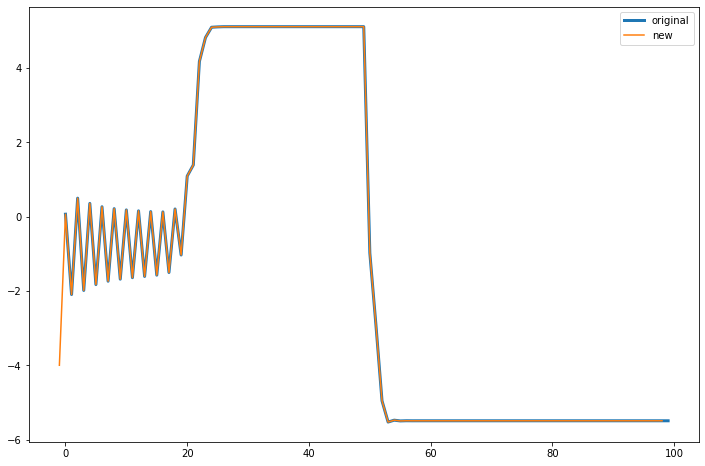

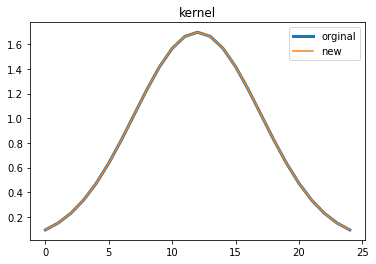

In [43]:

plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
plt.imshow(sim.data[p_u_1b].T, aspect='auto', cmap='Blues', vmin=0, vmax=1, interpolation='none')
plt.title('original')
plt.subplot(2, 1, 2)
plt.imshow(sim.data[p_u_2b].T, aspect='auto', cmap='Blues', vmin=0, vmax=1, interpolation='none')
plt.title('new')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(sim.data[p_u_1b][:,22], lw=3, label='original')
plt.plot(np.arange(100)-1, sim.data[p_u_2b][:,22], label='new')
plt.legend()
plt.show()

plt.plot(dft1b_kernels.kernel_matrix, lw=3, label='orginal')
plt.plot(kb, label='new')
plt.legend()
plt.title('kernel')
plt.show()


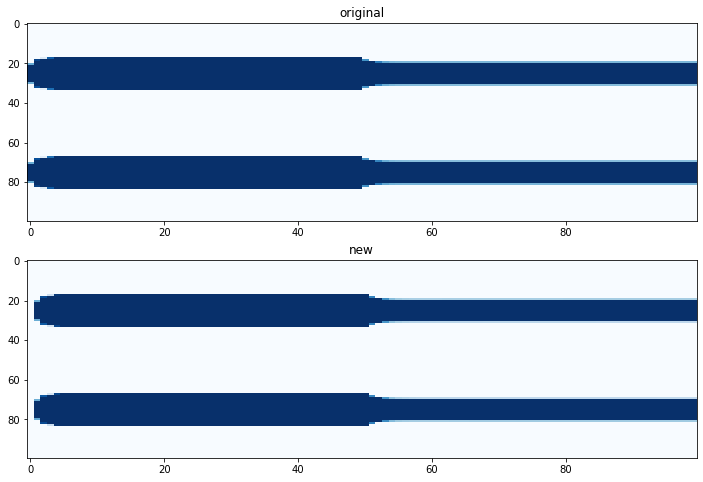

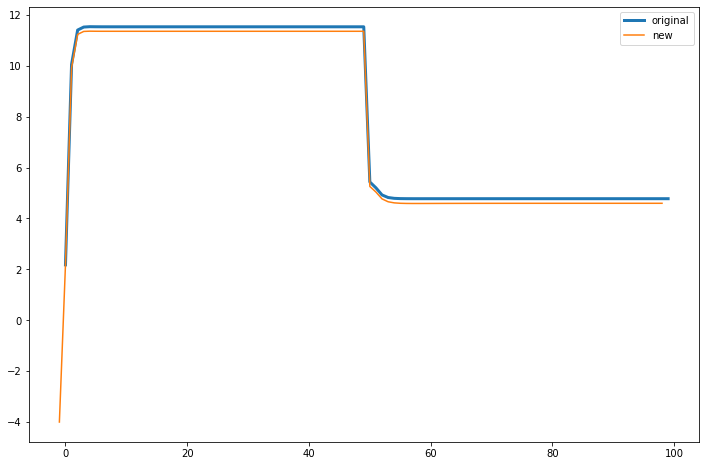

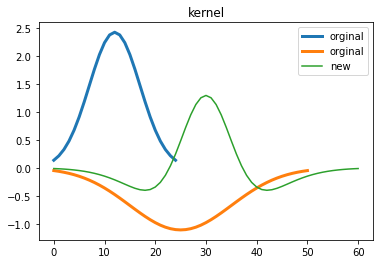

In [44]:

plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
plt.imshow(sim.data[p_u_1c].T, aspect='auto', cmap='Blues', vmin=0, vmax=1, interpolation='none')
plt.title('original')
plt.subplot(2, 1, 2)
plt.imshow(sim.data[p_u_2c].T, aspect='auto', cmap='Blues', vmin=0, vmax=1, interpolation='none')
plt.title('new')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(sim.data[p_u_1c][:,22], lw=3, label='original')
plt.plot(np.arange(100)-1, sim.data[p_u_2c][:,22], label='new')
plt.legend()
plt.show()

for kk in dft1c_kernels:
    plt.plot(kk.kernel_matrix, lw=3, label='orginal')
plt.plot(kc, label='new')
plt.legend()
plt.title('kernel')
plt.show()
